<a href="https://colab.research.google.com/github/bhattacharjee/mtu-nlp-assignment/blob/main/assignment1/pipeline_work_wbert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install spacy  nltk spacymoji huggingface -q       >/dev/null 2>&1         
!pip install -q -U tensorflow-text                      >/dev/null 2>&1
!pip install -q tf-models-official                      >/dev/null 2>&1
!python -m spacy download de_core_news_sm               >/dev/null 2>&1
!python -m spacy download de_dep_news_trf               >/dev/null 2>&1
!pip install transformers                               >/dev/null 2>&1

!python -m spacy download de_core_news_sm               >/dev/null 2>&1
!python -m spacy download de_dep_news_trf               >/dev/null 2>&1

!pip install mlxtend                                    >/dev/null 2>&1
!pip install imblearn                                   >/dev/null 2>&1

# handling emojis
!pip install demoji                                     >/dev/null 2>&1

In [2]:
import requests
def get_train_test_files():
    TRAIN_FILE = 'https://raw.githubusercontent.com/bhattacharjee/mtu-nlp-assignment/main/assignment1/Assessment1_Toxic_Train.csv'
    TEST_FILE = 'https://raw.githubusercontent.com/bhattacharjee/mtu-nlp-assignment/main/assignment1/Assessment1_Toxic_Test_For_Evaluation.csv'
    TRAIN_FILE_LOCAL = 'Assessment1_Toxic_Train.csv'
    TEST_FILE_LOCAL = 'Assessment1_Toxic_Test.csv'

    def download(url, localfile):
        with open(localfile, 'wb') as f:
            r = requests.get(url, allow_redirects=True)
            f.write(r.content)

    download(TRAIN_FILE, TRAIN_FILE_LOCAL)
    download(TEST_FILE, TEST_FILE_LOCAL)

    return TRAIN_FILE_LOCAL, TEST_FILE_LOCAL

import sklearn
def seed_random():
    import numpy as np
    import random
    np.random.seed(0)
    random.seed(0)

sklearn.set_config(display="diagram")

# Functions to read the CSV and do basic cleaning

In [3]:
import re
import pandas as pd
import demoji
from functools import lru_cache

def remove_roles(line:str)->str:
    # Remove texts like @USER, @MODERATOR etc
    pat = re.compile(u'\@[A-Za-z]+')
    return re.sub(pat, '', line)

@lru_cache(maxsize=3)
def get_train_test_df_cached():
    train_csv, test_csv = get_train_test_files()
    train_df = pd.read_csv(train_csv)
    test_df = pd.read_csv(test_csv)
    return train_df, test_df

def get_train_test_df():
    tr, te = get_train_test_df_cached()
    return tr.copy(), te.copy()

def remove_emojis(line:str)->str:
    # Replace emojis with their description, eg __thumbs_down__
    demoji_str = demoji.replace_with_desc(line, sep=" ::: ")
    if (demoji_str == line):
        return line
    
    inEmoji = False
    currentEmojiWords = []
    allWords = []

    def accumulate(word:str)->None:
        nonlocal inEmoji
        nonlocal currentEmojiWords
        nonlocal allWords
        if not inEmoji and word != ":::":
            allWords.append(word)
        elif inEmoji:
            if word == ':::':
                currentEmoji = "_".join(currentEmojiWords)
                currentEmoji = "__" + currentEmoji + "__"
                allWords.append(currentEmoji)
                currentEmojiWords = []
            else:
                currentEmojiWords.append(word)
        else: # Not in emoji but ::: is true
            inEmoji = True

    [accumulate(word) for word in demoji_str.split()]

    sentence = " ".join(allWords)
    return sentence


def remove_ellipses(line:str)->str:
    pat = re.compile(u'\.\.+')
    return re.sub(pat, ' ', line)

def to_lower(line:str)->str:
    return line.lower()

def replace_number_with_tag(line:str)->str:
    line = re.sub("\s\d*((\.|\,)\d+)?\s", " nummer ", line)
    line = re.sub('\s\d+$', '', line)
    line = re.sub('^\d+\s', '', line)
    return line

def remove_urls(line:str)->str:
    return re.sub('https?:\/\/\S+', ' hyperlink ', line)

def basic_clean(s:pd.Series)->pd.Series:
    return s.map(to_lower)                                                  \
            .map(remove_emojis)                                             \
            .map(remove_roles)                                              \
            .map(remove_ellipses)                                           \
            .map(replace_number_with_tag)                                   \
            .map(remove_urls)

@lru_cache(maxsize=3)
def get_clean_train_test_df_cached()->tuple:
    train_df, test_df = get_train_test_df()
    train_df['comment_text'] = basic_clean(train_df['comment_text'])
    test_df['comment_text'] = basic_clean(test_df['comment_text'])
    return train_df, test_df

def get_clean_train_test_df():
    tr, te = get_clean_train_test_df_cached()
    return tr.copy(), te.copy()

# Clean using Spacy and Enrich

In [4]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
import string
import spacy
from spacymoji import Emoji
import  de_core_news_sm

def is_punct_only(token:str)->bool:
    for c in list(token):
        if c not in string.punctuation:
            return False
    return True

def is_same(l1:list, l2:list)->bool:
    if (len(l1) != len(l2)):
        return False
    for x, y in zip(l1, l2):
        if x != y:
            return False
    return True

def get_num_of_allcap_words(s:str)->int:
    def is_allcaps(s:str)->bool:
        if (len(s) < 3):
            return False
        for c in list(s):
            if not (\
                    (ord(c) <=ord('Z') and ord(c) >= ord('A')) or           \
                    (ord(c) >= ord('0') and ord(c) <= ord('9'))             \
                    ):
                return False
        return True

    if len(s) < 3:
        return 0
    tokens = [w.strip() for w in s.split()]
    return sum([1 for t in tokens if is_allcaps(t)])

def get_percentage_of_excalamations(s:str)->float:
    if len(s) == 0:
        return 0.0
    exclamation_count = sum([1 for c in list(s) if c == '!'])
    return exclamation_count / len(s)


def is_empty_string(s:str)->bool:
    if s == '' or s == None:
        return True
    return False

def do_basic_nlp_cleaning(line:str)->str:
    nltk.download('stopwords', quiet=True)
    nltk.download('punkt', quiet=True)
    nltk.download('wordnet', quiet=True)

    # Tokenize
    tokens = word_tokenize(line)

    # Some tokens start with a punctuation, remove the first one
    def remove_first_punctuation(tok:str)->str:
        return                                                              \
            tok[1:]                                                         \
            if tok[0] in set(string.punctuation) and len(tok) != 0          \
            else tok

    tokens = [remove_first_punctuation(w) for w in tokens]

    # Remove stop words
    stop_words = set(stopwords.words("german"))
    tokens = [w for w in tokens if w not in stop_words]

    # Remove punctuations
    tokens = [w for w in tokens if not is_punct_only(w)]

    # Stem words
    stem = SnowballStemmer('german')
    tokens = [stem.stem(w) for w in tokens]

    return " ".join(tokens)

def get_cleaning_function(remove_named_ents:bool=True, pos_tagging:bool=False):
    #nlp = spacy.load("de_dep_news_trf")
    #nlp = spacy.load("de_core_news_sm")
    nlp = de_core_news_sm.load()
    emoji = Emoji(nlp)
    nlp.add_pipe(emoji, first=True)
    stopwords = spacy.lang.de.stop_words.STOP_WORDS

    def do_basic_nlp_cleaning(line:str)->str:
        def is_interesting_token(token, doc):
            if token.pos_ in set(['NUM', 'SYM']):
                return False
            if remove_named_ents:
                for e in doc.ents:
                    for t in e:
                        if token.text == t.text:
                            return False
            if token.text in stopwords:
                return False
            if (token.is_punct):
                return False
            #if token._.is_emoji:
            #    return False
            return True

        def remove_terminal_punctuations(word):
            word = word.strip()
            while word != "" and word[0] in list(string.punctuation):
                word = word[1:]
            while word != "" and word[-1] in list(string.punctuation):
                word = word[:-1]
            return word

        def get_final_string(tok, doc):
            lemma = tok.lemma_.lower()
            if pos_tagging:
                lemma = lemma + ":" + tok.pos_
                lemma = lemma + ":" + tok.tag_
            return lemma

        doc = nlp(line)
        words = [get_final_string(tok, doc) for tok in doc if is_interesting_token(tok, doc)]
        words = [remove_terminal_punctuations(word) for word in words]
        words = [word for word in words if word != ""]
        return  " ".join(words)

    return do_basic_nlp_cleaning

def get_enriched_dataset(df):
    cleaning_fn = get_cleaning_function(remove_named_ents=True, pos_tagging=False)
    df['cleaned_comment_text'] = df['comment_text'].map(cleaning_fn)
    df['n_all_caps'] = df['comment_text'].map(get_num_of_allcap_words)
    df['perc_exclamations'] = df['comment_text'].map(get_percentage_of_excalamations)
    df['num_exclamations'] = df['comment_text'].map(lambda s: sum([1 for x in list(s) if x == '!']))
    return df

@lru_cache(maxsize=3)
def get_final_enriched_dataset_cached():
    tr, te = get_clean_train_test_df()
    tr = get_enriched_dataset(tr)
    te = get_enriched_dataset(te)
    return tr.copy(), te.copy()

def get_final_enriched_dataset():
    tr, te = get_final_enriched_dataset_cached()
    return tr.copy(), te.copy()

train_df, test_df = get_final_enriched_dataset()

#cleaning_fn = get_cleaning_function(remove_named_ents=True, pos_tagging=False)
#train_df, test_df = get_clean_train_test_df()
#train_df = get_enriched_dataset(train_df)
#test_df = get_enriched_dataset(test_df)
#empty_rows = train_df['cleaned_comment_text'].map(is_empty_string
#train_df = train_df[~ empty_rows]

# Print Enriched Training DF

In [5]:
train_df

,comment_text,Sub1_Toxic,Sub2_Engaging,Sub3_FactClaiming,cleaned_comment_text,n_all_caps,perc_exclamations,num_exclamations
0,"gestern bei illner, montag bei nummer ist das...",1,0,1,gestern illner montag nummer langsam ör-partei...,0,0.000000,0
1,mein gott der war erst gestern bei illner. die...,1,0,1,gestern redaktionen versagen,0,0.000000,0
2,die cdu lässt das so wie so nicht zu . sagen ...,1,0,1,lässt sagen reich bekommen nummer milliarden h...,0,0.000000,0
3,bei meiner beschissenen rente als 2x geschiede...,1,0,1,beschissen rente geschieden mann steuern krank...,0,0.000000,0
4,"wer nummer jahre zum mindestlohn arbeiten muß,...",1,1,1,nummer mindestlohn arbeiten erhalten € rente n...,0,0.005025,3
...,...,...,...,...,...,...,...,...
3189,hier mal eine info. flüchtlinge werden nummer ...,0,0,0,mal info flüchtlinge nummer km schlauchboote s...,0,0.000000,0
3190,.aha .mal abwarten kommt bei uns auch .firmen ...,1,0,1,aha mal abwarten entlassen mitarbeiter pressen...,0,0.000000,0
3191,.so ist es,0,0,0,so,0,0.000000,0
3192,.die warten da,0,0,0,die warten,0,0.000000,0


# HuggingFace

In [6]:
import os
import shutil

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization
import tensorflow as tf
import tensorflow_hub as hub
import IPython
import matplotlib.pyplot as plt


tfhub_handle_encoder = "https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1"
tfhub_handle_preprocess = "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3"

bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)
bert_model = hub.KerasLayer(tfhub_handle_encoder)

def plot_model(model):
    plot = tf.keras.utils.plot_model(model, show_shapes=True, \
                                            expand_nested=True)
    IPython.display.display(plot)


def plot_history(history):
    plt.rcParams["figure.figsize"] = [30, 10]
    plt.plot(history['loss'], label='loss', color='b')
    plt.plot(history['val_loss'], label='val_loss', color='b', linestyle='dashdot')
    plt.plot(history['accuracy'], label='acc', color='g')
    plt.plot(history['val_accuracy'], label='acc', color='g', linestyle='dashdot')
    plt.legend()
    plt.show()

In [35]:
from transformers import AutoTokenizer,TFAutoModel
from transformers import AutoTokenizer, AutoModelForMaskedLM, TFAutoModelForMaskedLM
import tensorflow as tf
import sklearn
from sklearn.model_selection import train_test_split
import numpy as np
import IPython

SEQUENCE_LENGTH = 512

bert_tokenizer = AutoTokenizer.from_pretrained("bert-base-german-cased")

def tokenize_input_with_bert(bert_tokenizer, input:str):
    tokens = bert_tokenizer.encode_plus(
                    input,
                    max_length=SEQUENCE_LENGTH,
                    truncation=True,
                    padding='max_length',
                    add_special_tokens=True,
                    return_attention_mask=True,
                    return_token_type_ids=False,
                    return_tensors='np'
                )
    return tokens['input_ids'], tokens['attention_mask']

def tokenize_input_with_bert(bert_tokenizer, input:str, seq_len:int):
    def pad(t):
        try:
            t = t.reshape((t.shape[1],))
        except:
            pass
        t = t[:seq_len]
        pad_len = max(0, seq_len - t.shape[0])
        t = np.pad(t, (0, pad_len))
        t = t.reshape((1, t.shape[0]))
        return t

    tokens = bert_tokenizer(
                    input,
                    truncation=True,
                    add_special_tokens=True,
                    return_attention_mask=True,
                    return_token_type_ids=False,
                    return_tensors='np')

    return pad(tokens['input_ids']), pad(tokens['attention_mask'])

def tokenize_dataframe_of_text(df, seq_len:int):
    x_ids = np.zeros((0, seq_len))
    x_mask = np.zeros((0, seq_len))

    for i, text in enumerate(df):
        id, mask = tokenize_input_with_bert(bert_tokenizer, text, seq_len)
        x_ids = np.append(x_ids, id, axis=0)
        x_mask = np.append(x_mask, mask, axis=0)

    return x_ids, x_mask

class SimpleBertModel():
    @staticmethod
    def build_model(seq_len):
        
        input_ids = tf.keras.layers.Input(shape=(seq_len,), name='input_ids', dtype='int32')
        mask = tf.keras.layers.Input(shape=(seq_len,), name='attn_mask', dtype='int32')
    
        bert_model = TFAutoModelForMaskedLM.from_pretrained("bert-base-german-cased")
    
        X = bert_model(input_ids, attention_mask=mask)
        X = X[0]
        X = tf.keras.layers.BatchNormalization()(X)
        X = tf.keras.layers.Dense(128, activation='relu')(X)
        X = tf.keras.layers.Dropout(0.1)(X)
        X = tf.keras.layers.Flatten()(X)
        y = tf.keras.layers.Dense(1, activation='softmax', name='outputs')(X)
    
        model = tf.keras.Model(inputs=[input_ids, mask], outputs=y)
    
        bert_model.trainable = False
        optimizer = tf.keras.optimizers.Adam()
        loss = tf.keras.losses.BinaryCrossentropy(from_logits=False)
        model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
    
        return model

def get_new_shape(sh):
    # Add a new dimension
    sh = list(sh)
    sh = sh[1:] + [1]
    sh = tuple(sh)
    return sh

class BertCNNModel():
    def build_model(seq_len):
        
        input_ids = tf.keras.layers.Input(shape=(seq_len,), name='input_ids', dtype='int32')
        mask = tf.keras.layers.Input(shape=(seq_len,), name='attn_mask', dtype='int32')
    
        bert_model = TFAutoModelForMaskedLM.from_pretrained("bert-base-german-cased")
    
        X = bert_model(input_ids, attention_mask=mask)
        X = X[0]
        X = tf.keras.layers.BatchNormalization()(X)
        X = tf.keras.layers.Reshape(get_new_shape(X.shape))(X)
        X = tf.keras.layers.Conv2D(64, (3,3), padding='same', activation='relu')(X)
        X = tf.keras.layers.MaxPooling2D((2, 2,))(X)
        X = tf.keras.layers.Flatten()(X)
        y = tf.keras.layers.Dense(1, activation='softmax', name='outputs')(X)
    
        model = tf.keras.Model(inputs=[input_ids, mask], outputs=y)
    
        bert_model.trainable = False
        optimizer = tf.keras.optimizers.Adam()
        loss = tf.keras.losses.BinaryCrossentropy(from_logits=False)
        model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
    
        return model


def fit_model(model, X, y, num_epochs=5):
    X_ids, X_masks = tokenize_dataframe_of_text(X, SEQUENCE_LENGTH)
    ds = tf.data.Dataset.from_tensor_slices((X_ids, X_masks, y))

    def map_fn(input_ids, masks, labels):
        return {'input_ids': input_ids, 'attn_mask': masks}, labels
    ds = ds.map(map_fn)

    ds = ds.shuffle(10000).batch(32)

    train_ds = ds.take((len(ds) * 8) // 10)
    val_ds = ds.skip((len(ds) * 8) // 10)

    model = build_model(SEQUENCE_LENGTH)

    history = model.fit(train_ds, validation_data=val_ds, epochs=num_epochs)

    return history

def create_model():
    return BertCNNModel.build_model(SEQUENCE_LENGTH)


@lru_cache(maxsize=3)
def get_clean_train_test_df_cached()->tuple:
    train_df, test_df = get_train_test_df()
    train_df['comment_text'] = basic_clean(train_df['comment_text'])
    test_df['comment_text'] = basic_clean(test_df['comment_text'])
    cleaning_fn = get_cleaning_function(remove_named_ents=True, pos_tagging=False)
    train_df = get_enriched_dataset(train_df)
    return train_df, test_df

def get_clean_train_test_df()->tuple:
    tr, te = get_clean_train_test_df_cached()
    return tr.copy(), te.copy()

def get_enriched_dataset(df):
    cleaning_fn = get_cleaning_function(remove_named_ents=True, pos_tagging=False)
    df['comment_text'] = df['comment_text'].map(cleaning_fn)
    return df

@lru_cache(maxsize=3)
def get_enriched_train_test_df_cached():
    tr, te = get_clean_train_test_df()
    tr = get_enriched_dataset(tr)
    te = get_enriched_dataset(te)
    return tr, te

def get_enriched_train_test_df():
    tr, te = get_enriched_train_test_df_cached()
    return tr.copy(), te.copy()

def run_bert_model(model, target_column:str, num_epochs:int):
    print("Simple Bert Model: ", target_column)
    plot_model(model)
    train_df, test_df = get_enriched_train_test_df()
    history = fit_model(model, train_df['comment_text'], train_df[target_column])
    plot_history(history.history)

"""
model = create_model()
train_df, test_df = get_clean_train_test_df()
train_df = get_enriched_dataset(train_df)
test_df = get_enriched_dataset(test_df)
history = fit_model(model, train_df['comment_text'], train_df['Sub1_Toxic'])
"""


"\nmodel = create_model()\ntrain_df, test_df = get_clean_train_test_df()\ntrain_df = get_enriched_dataset(train_df)\ntest_df = get_enriched_dataset(test_df)\nhistory = fit_model(model, train_df['comment_text'], train_df['Sub1_Toxic'])\n"

All model checkpoint layers were used when initializing TFBertForMaskedLM.

All the layers of TFBertForMaskedLM were initialized from the model checkpoint at bert-base-german-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForMaskedLM for predictions without further training.


Simple Bert Model:  Sub1_Toxic


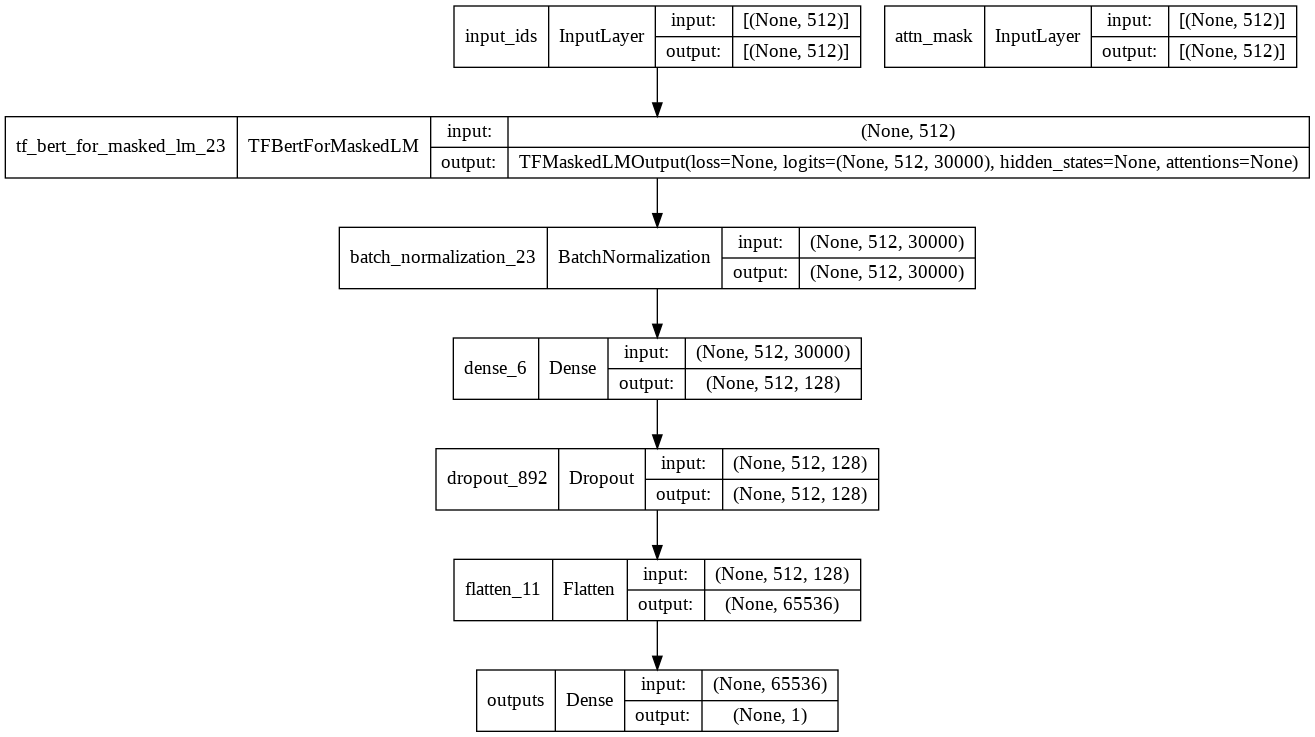

In [ ]:
colnames = ['Sub1_Toxic', 'Sub2_Engaging', 'Sub3_FactClaiming']
for name in colnames:
    run_bert_model(SimpleBertModel.build_model(SEQUENCE_LENGTH), name, 5)